##   Improving performance for DataFrame Transformations


---------
The material in this notebook was extracted from
* Spark The Definitive Guide Big Data Processing Made Simple (2018)
---------


### Contents

* Pyspark sintaxis vs SQL sintaxis for DataFrame Transformations
* Optimization of Data Transform (pivot example for hashing)
* Exploring Joins
* Playing with partitions

> Remmember to always take your data distribution among partitions into consideration

Query optimizations on DataFrames transformations using SPARK SQL Lib

In [1]:
#Libraries and modules
import pandas as pd

import matplotlib as plt
import seaborn as sns

import time
import gc

import pyspark.sql.functions as F
from pyspark.sql import Row
from pyspark.sql.types import IntegerType, StringType, DoubleType, FloatType
from pyspark.sql.window import Window
from pyspark.sql.functions import broadcast

from itertools import chain
from pyspark.sql.functions import create_map, lit

### 2. Data

> DATA open source
#### Context

<p style="text-align: justify;">
The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights is published in DOT's monthly Air Travel Consumer Report and in this dataset of 2015 flight delays and cancellations.
</p>

##### source: https://www.kaggle.com/usdot/flight-delays

In [1]:
#LOAD & DISPLAY DATA
## /data/sandboxes/fmex/data/curso_dsf_20190402/data/

print ('AIRLINES')
df_airlines = spark.read.csv('./data/airlines.csv', inferSchema=True, header=True)
df_airlines.show(5,truncate = False) 
print ('#rows: ',df_airlines.count(),'\n')

df_airlines.printSchema()

AIRLINES
+---------+----------------------+
|IATA_CODE|AIRLINE               |
+---------+----------------------+
|UA       |United Air Lines Inc. |
|AA       |American Airlines Inc.|
|US       |US Airways Inc.       |
|F9       |Frontier Airlines Inc.|
|B6       |JetBlue Airways       |
+---------+----------------------+
only showing top 5 rows

#rows:  14 

root
 |-- IATA_CODE: string (nullable = true)
 |-- AIRLINE: string (nullable = true)



In [5]:
#LOAD & DISPLAY DATA

print ('AIRPORTS')
df_airports = spark.read.csv('./data/airports.csv', inferSchema=True, header=True)
df_airports.show(5, truncate = False) 
print ('#rows: ',df_airports.count(),'\n')

df_airports.printSchema()

AIRPORTS
+---------+-----------------------------------+-----------+-----+-------+--------+----------+
|IATA_CODE|AIRPORT                            |CITY       |STATE|COUNTRY|LATITUDE|LONGITUDE |
+---------+-----------------------------------+-----------+-----+-------+--------+----------+
|ABE      |Lehigh Valley International Airport|Allentown  |PA   |USA    |40.65236|-75.4404  |
|ABI      |Abilene Regional Airport           |Abilene    |TX   |USA    |32.41132|-99.6819  |
|ABQ      |Albuquerque International Sunport  |Albuquerque|NM   |USA    |35.04022|-106.60919|
|ABR      |Aberdeen Regional Airport          |Aberdeen   |SD   |USA    |45.44906|-98.42183 |
|ABY      |Southwest Georgia Regional Airport |Albany     |GA   |USA    |31.53552|-84.19447 |
+---------+-----------------------------------+-----------+-----+-------+--------+----------+
only showing top 5 rows

#rows:  322 

root
 |-- IATA_CODE: string (nullable = true)
 |-- AIRPORT: string (nullable = true)
 |-- CITY: string (nu

In [6]:
#LOAD & DISPLAY DATA

print ('FLIGHTS')
df_flights = spark.read.csv('./data/flights.csv', inferSchema=True, header=True)
display(df_flights.sample(False, 0.005, seed=0).toPandas().head(5))
print ('#rows: ',df_flights.count())
print ('#cols: ',len(df_flights.columns), '\n')

df_flights.printSchema()

FLIGHTS


22/05/03 13:59:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,B6,1678,N618JB,JAX,JFK,600,...,816.0,8.0,0,0,None,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,UA,220,N813UA,MSY,EWR,608,...,946.0,-14.0,0,0,None,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,AA,2326,N3KEAA,MIA,DCA,645,...,946.0,31.0,0,0,None,0.0,0.0,0.0,31.0,0.0
3,2015,1,1,4,AS,582,N611AS,PDX,SNA,650,...,859.0,-10.0,0,0,None,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,WN,923,N922WN,SJU,FLL,730,...,917.0,-3.0,0,0,None,NaN,NaN,NaN,NaN,NaN


#rows:  5819079
#cols:  31 

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |--

### 3. Pyspark sintaxis vs SQL sintaxis for DataFrame Transformations

#### Programming interface


Internally, Spark uses an engine called **Catalyst** that maintains its own type information through the planning and processing of work.



<p style="text-align: justify;">
Catalyst is the Spark SQL query optimizer, which is used to take the query plan and transform it into an execution plan that Spark can run. Much as our transformations on RDDs build up a DAG, as you apply relational and functional transformations on DataFrames/Datasets, Spark SQL builds up a tree representing our query plan, called a logical plan. Spark is able to apply a number of optimizations on the logical plan and can also choose between multiple physical plans for the same logical plan using a cost-based model.
</p>

**There is no performance difference between writing SQL queries or writing DataFrame code, they both “compile” to the same underlying plan that we specify in DataFrame code**. This makes it possible for you to specify transformations in the manner most convenient to you at any given point in time and not sacrifice any efficiency to do so!

To understand that this is happening, let’s take a look at two explain plans, trying to answer a simple question:

*How many trips (origin-destination) were concluded?*

In [15]:
# SQL WAY
start_time = time.time() #t0
df_flights.createOrReplaceTempView("table_flights")
sql_way = spark.sql("""
    select 
        ORIGIN_AIRPORT, 
        DESTINATION_AIRPORT, 
        count(*) as quantity 
    from table_flights 
    where CANCELLED = 0
    group by ORIGIN_AIRPORT, DESTINATION_AIRPORT
""")
print('SQL WAY'), sql_way.show()
print("--- %s seconds --- \n" % (time.time() - start_time))

# PYSPARK WAY
start_time = time.time() #t0
pyspark_way = df_flights.filter(F.col('CANCELLED') == 0)\
            .select('ORIGIN_AIRPORT','DESTINATION_AIRPORT')\
            .groupBy('ORIGIN_AIRPORT','DESTINATION_AIRPORT')\
            .agg(F.count('*').alias('quantity'))
print('PYSPARK WAY'), pyspark_way.show()
print("--- %s seconds --- \n" % (time.time() - start_time))

SQL WAY
+--------------+-------------------+--------+
|ORIGIN_AIRPORT|DESTINATION_AIRPORT|quantity|
+--------------+-------------------+--------+
|           BQN|                MCO|     441|
|           PHL|                MCO|    4805|
|           MCI|                IAH|    1674|
|           SPI|                ORD|     956|
|           SNA|                PHX|    3811|
|           LBB|                DEN|     592|
|           ORD|                PDX|    2113|
|           EWR|                STT|     236|
|           ATL|                GSP|    2453|
|           MCI|                MKE|     611|
|           PBI|                DCA|     964|
|           SMF|                BUR|    2059|
|           MDW|                MEM|     609|
|           LAS|                LIT|     332|
|           TPA|                ACY|     332|
|           DSM|                EWR|     184|
|           FSD|                ATL|     328|
|           SJC|                LIH|     190|
|           CLE|          

**... explain plans**

        (When EXPLAIN is used with an explainable statement, it displays information from the optimizer about the statement execution plan. That is, the program explains how it would process the statement, including information about, for example, how tables are joined and in which order)

In [16]:
#explain plans
sql_way.explain()
print ('\n')
pyspark_way.explain()

== Physical Plan ==
*(2) HashAggregate(keys=[ORIGIN_AIRPORT#737, DESTINATION_AIRPORT#738], functions=[count(1)])
+- Exchange hashpartitioning(ORIGIN_AIRPORT#737, DESTINATION_AIRPORT#738, 200)
   +- *(1) HashAggregate(keys=[ORIGIN_AIRPORT#737, DESTINATION_AIRPORT#738], functions=[partial_count(1)])
      +- *(1) Project [ORIGIN_AIRPORT#737, DESTINATION_AIRPORT#738]
         +- *(1) Filter (isnotnull(CANCELLED#754) && (CANCELLED#754 = 0))
            +- *(1) FileScan csv [ORIGIN_AIRPORT#737,DESTINATION_AIRPORT#738,CANCELLED#754] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/luis/Documents/Work/Courses/DSP_20191013/Spark/data/flights.csv], PartitionFilters: [], PushedFilters: [IsNotNull(CANCELLED), EqualTo(CANCELLED,0)], ReadSchema: struct<ORIGIN_AIRPORT:string,DESTINATION_AIRPORT:string,CANCELLED:int>


== Physical Plan ==
*(2) HashAggregate(keys=[ORIGIN_AIRPORT#737, DESTINATION_AIRPORT#738], functions=[count(1)])
+- Exchange hashpartitioning(ORIGIN_AIRPORT#737, DES

<p style="text-align: center;">
Notice that these plans compile to the exact same underlying plan!
<p>

**Now we can query our data in SQL. Great! :)**

**You can express your business logic in SQL or DataFrames and Spark will compile that logic down to an underlying plan (that you can see in the explain plan) before actually executing your code.** 

### 4. Optimization of Data Transforms

There are two versions of pivot function: one that requires the caller to specify the list of distinct values to pivot on, and one that does not. The latter is more concise but less efficient, because Spark needs to first compute the list of distinct values internally. [2]

    [2] http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html?highlight=pivot
    
> Take hashing into considerations

In [20]:
# PYSPARK TRADITIONAL WAY
start_time = time.time() #t0

pyspark_way_1 = df_flights.filter(F.col('CANCELLED') == 1) \
            .select('AIRLINE','ORIGIN_AIRPORT','CANCELLATION_REASON') \
            .groupBy('AIRLINE','ORIGIN_AIRPORT','CANCELLATION_REASON') \
            .agg(F.count('*').alias('cancelation_quantity'))
pyspark_way_1 = pyspark_way_1.groupBy('AIRLINE','ORIGIN_AIRPORT') \
            .pivot('CANCELLATION_REASON') \
            .agg(F.sum('cancelation_quantity')) \
            .na.fill(0)
pyspark_way_1 = pyspark_way_1.select(F.col('AIRLINE'), F.col('ORIGIN_AIRPORT'),
                                 F.col('A').alias('Airline_Carrier'),
                                 F.col('B').alias('Weather'), 
                                 F.col('C').alias('National_Air_System'), 
                                 F.col('D').alias('Security'))\
                    .sort('AIRLINE','Weather', ascending = [1,0])
print('PYSPARK WAY'), pyspark_way_1.show()
t2 = time.time() - start_time
print("--- %s seconds ---" % t2)

PYSPARK WAY
+-------+--------------+---------------+-------+-------------------+--------+
|AIRLINE|ORIGIN_AIRPORT|Airline_Carrier|Weather|National_Air_System|Security|
+-------+--------------+---------------+-------+-------------------+--------+
|     AA|           DFW|            376|   2309|                 77|       0|
|     AA|           ORD|            311|    636|                 61|       0|
|     AA|           LGA|            166|    305|                143|       0|
|     AA|           MIA|            152|    290|                 24|       2|
|     AA|           JFK|             46|    249|                 23|       0|
|     AA|         11298|              7|    214|                  0|       0|
|     AA|           BOS|            127|    211|                 63|       0|
|     AA|           LAX|            139|    175|                  9|       0|
|     AA|           DCA|            115|    173|                 88|       0|
|     AA|           AUS|             58|    135|    

In [17]:
# PYSPARK 2nd WAY
start_time = time.time() #t0

pyspark_way_2 = df_flights.filter(F.col('CANCELLED') == 1) \
            .select(F.col('AIRLINE'),'ORIGIN_AIRPORT','CANCELLATION_REASON') \
            .groupBy('AIRLINE','ORIGIN_AIRPORT','CANCELLATION_REASON') \
            .agg(F.count('*').alias('cancelation_quantity'))
pyspark_way_2 = pyspark_way_2.groupBy('AIRLINE','ORIGIN_AIRPORT') \
            .pivot('CANCELLATION_REASON', ["A","B","C","D"]) \
            .agg(F.sum('cancelation_quantity')) \
            .na.fill(0)

pyspark_way_2 = pyspark_way_2.select(F.col('AIRLINE'), F.col('ORIGIN_AIRPORT'),
                                 F.col('A').alias('Airline_Carrier'),
                                 F.col('B').alias('Weather'), 
                                 F.col('C').alias('National_Air_System'), 
                                 F.col('D').alias('Security'))\
                    .sort('AIRLINE','Weather', ascending = [1,0])
print('PYSPARK WAY'), pyspark_way_2.show()
t3 = time.time() - start_time
print("--- %s seconds ---" % t3)

PYSPARK WAY
+-------+--------------+---------------+-------+-------------------+--------+
|AIRLINE|ORIGIN_AIRPORT|Airline_Carrier|Weather|National_Air_System|Security|
+-------+--------------+---------------+-------+-------------------+--------+
|     AA|           DFW|            376|   2309|                 77|       0|
|     AA|           ORD|            311|    636|                 61|       0|
|     AA|           LGA|            166|    305|                143|       0|
|     AA|           MIA|            152|    290|                 24|       2|
|     AA|           JFK|             46|    249|                 23|       0|
|     AA|         11298|              7|    214|                  0|       0|
|     AA|           BOS|            127|    211|                 63|       0|
|     AA|           LAX|            139|    175|                  9|       0|
|     AA|           DCA|            115|    173|                 88|       0|
|     AA|           AUS|             58|    135|    

<p style="text-align: center;">
It is recommended to provide column data (if known) as an argument to pivot function!
<p>

Another approach is to do two phase aggregation. Spark2.0 uses this implementation in-order to improve the performance Spark-13749 [3].

    [3] https://sparkbyexamples.com/how-to-pivot-table-and-unpivot-a-spark-dataframe/

In [18]:
# PYSPARK 3rd WAY
start_time = time.time() #t0

pyspark_way_3 = df_flights.filter(F.col('CANCELLED') == 1) \
            .select(F.col('AIRLINE'),'ORIGIN_AIRPORT','CANCELLATION_REASON') \
            .groupBy('AIRLINE','ORIGIN_AIRPORT','CANCELLATION_REASON') \
            .agg(F.count('*').alias('cancelation_quantity'))
pyspark_way_3 = pyspark_way_3.groupBy('AIRLINE','ORIGIN_AIRPORT','CANCELLATION_REASON') \
            .agg(F.sum('cancelation_quantity').alias('suma'))\
            .groupBy('AIRLINE','ORIGIN_AIRPORT')\
            .pivot('CANCELLATION_REASON',["A","B","C","D"]) \
            .agg(F.sum('suma')) \
            .na.fill(0)
pyspark_way_3 = pyspark_way_3.select(F.col('AIRLINE'), F.col('ORIGIN_AIRPORT'),
                                 F.col('A').alias('Airline_Carrier'),
                                 F.col('B').alias('Weather'), 
                                 F.col('C').alias('National_Air_System'), 
                                 F.col('D').alias('Security'))\
                    .sort('AIRLINE','Weather', ascending = [1,0])
print('PYSPARK WAY'), pyspark_way_3.show()
t4 = time.time() - start_time
print("--- %s seconds ---" % t4)

PYSPARK WAY
+-------+--------------+---------------+-------+-------------------+--------+
|AIRLINE|ORIGIN_AIRPORT|Airline_Carrier|Weather|National_Air_System|Security|
+-------+--------------+---------------+-------+-------------------+--------+
|     AA|           DFW|            376|   2309|                 77|       0|
|     AA|           ORD|            311|    636|                 61|       0|
|     AA|           LGA|            166|    305|                143|       0|
|     AA|           MIA|            152|    290|                 24|       2|
|     AA|           JFK|             46|    249|                 23|       0|
|     AA|         11298|              7|    214|                  0|       0|
|     AA|           BOS|            127|    211|                 63|       0|
|     AA|           LAX|            139|    175|                  9|       0|
|     AA|           DCA|            115|    173|                 88|       0|
|     AA|           AUS|             58|    135|    

In [21]:
#summary performance
print("PYSPARK traditional WAY --- %s seconds --- \n" % t2)
print("PYSPARK 2nd WAY (distinct values known) --- %s seconds --- \n" % t3)
print("PYSPARK 3rd WAY (distinct values known + two phase aggregation)--- %s seconds --- \n" % t4)

PYSPARK traditional WAY --- 7.210438966751099 seconds --- 

PYSPARK 2nd WAY (distinct values known) --- 4.772249221801758 seconds --- 

PYSPARK 3rd WAY (distinct values known + two phase aggregation)--- 4.455962419509888 seconds --- 



### 5. Exploring Joins

We’re going to focus on the high-level examples to help you understand exactly what’s going on in some of the more
common scenarios, and let you take advantage on that you can use right away to try to speed up some of your workloads.


First of some words about the most basic concept — a partition:


__Partition__ — a logical chunk of a large data set.

Very often data we are processing can be separated into logical partitions (ie. payments from the same country, ads displayed for given cookie, etc). In Spark, they are distributed among nodes when _shuffling_ occurs. [4]



    [4] High Performance Spark by Holden Karau and Rachel Warren. Published by O’Reilly Media, Inc. 

**Choosing an Execution Plan...**

 - Shuffled  hash join 
 
 _(default implementation of join in Spark)_

In order to join data, **Spark needs the data that is to be joined (i.e. the data based on each key) to live on the same partition**. The default implementation of join in Spark is a **shuffled  hash join. The shuffled hash join ensures that data on each partition will contain the same keys by partitioning the second dataset with the same default partitioner as the first**, so that the keys with the same hash value from both datasets are in  the same partition. While this approach always works, it can be more expensive than necessary because it requires a shuffle. 


_So, an interesting question could be: if this join is causing a large volume of data shuffling (read) making this operation is quite slow, how to avoid this such shuffling?_

The shuffle can be avoided if:

1. Both RDDs have a known partitioner.

2. One of the datasets is small enough to fit in memory, in which case we can do a broadcast hash join (we will explain what this is later).

> Spark SQL supports the same basic join types as core Spark, but the optimizer is able to do more of the heavy lifting for you - although you also give up some of our control. For example, Spark SQL can sometimes push down or re-order operations to make our joins more efficient. On the other hand, you don’t control the partitioner for DataFrames or Datasets, so you can’t manually avoid shuffles as you did with core Spark joins.

In a shuffled join, every node talks to every other node and **they share data according to which node has a certain key or set of keys** (on which you are joining). This means that all worker nodes (and potentially every partition) will need to communicate with one another during the entire join process (with no intelligent partitioning of data).

In [22]:
#...to parquet format
df_flights.write.mode('overwrite').format("parquet").save('../data/df_1_wop.parquet')
df_1_wop = spark.read.parquet('../data/df_1_wop.parquet')

# Shuffled hash join (with NO intelligent partitioning of data)
start_time = time.time() #t0

df_1 = df_1_wop
df_2 = df_1
df_joined = df_1.join(df_2, 
         (df_1.MONTH == df_2.MONTH) & 
         (df_1.DAY == df_2.DAY) &
         (df_1.AIRLINE == df_2.AIRLINE) &
         (df_1.FLIGHT_NUMBER == df_2.FLIGHT_NUMBER)
         , how = 'left')
df_joined.show(1)

print("--- %s seconds --- \n" % (time.time() - start_time))
print("Number of partitions (default config): {} \n".format(df_joined.rdd.getNumPartitions()))

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

 -  Broadcast Hash Join

When the table is small enough to fit into the memory of a single worker node we can optimize our join. **What this means is that we will replicate our small DataFrame onto every worker node in the cluster** (be it located on one machine or many). What this does is prevent us from performing the all-to-all communication during the entire join process; instead, we perform it only once at the beginning and then let each individual worker node perform the work without having to wait or communicate with any other worker node.

With the DataFrame API, we can also explicitly give the optimizer a hint that we would like to use a broadcast join by using the correct function around the small DataFrame in question. 

In [23]:
#df_airlines.shape =(14 filas x 2 columnas) ----> Small Dataset  
#df_flights.shape =(~6MM filas x 31 columnas) ----> Big Dataset  

# Shuffled hash join (default)
start_time = time.time() #t0
df_flights.join(df_airlines,
                df_airlines.IATA_CODE == df_flights.AIRLINE,
                how='left').drop('IATA_CODE').show(5)
print("Default Join --- %s seconds --- \n" % (time.time() - start_time))
t1 = time.time() - start_time

# Broadcast hash join
start_time = time.time() #t0
df_flights.join(broadcast(df_airlines),
                df_airlines.IATA_CODE == df_flights.AIRLINE,
                how='left').drop('IATA_CODE').show(5)
print("Broadcast Join --- %s seconds --- \n" % (time.time() - start_time))
t2 = time.time() - start_time

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+--------------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|             AIRLINE|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+-------

- Map values in a dataframe from a dictionary

Using _dictionary_ + _df.withColumn_ to map values in a specific column in a dataframe.

In [24]:
#df_airlines.shape =(14 filas x 2 columnas) ----> Small Dataset  
#df_flights.shape =(~6MM filas x 31 columnas) ----> Big Dataset  

# Using dictionary + df.withColumn
## "when" way
start_time = time.time() #t0
df_flights.withColumn('new_column',
            F.when(F.col('AIRLINE').isin('UA'), 'United Air Lines Inc.')
            .otherwise(F.when(F.col('AIRLINE').isin('AA'), 'American Airlines Inc.')
                       .otherwise(F.when(F.col('AIRLINE').isin('US'), 'US Airways Inc.')
                                  .otherwise(F.when(F.col('AIRLINE').isin('F9'), 'Frontier Airlines Inc.')
                                             .otherwise(F.when(F.col('AIRLINE').isin('B6'), 'JetBlue Airways')
                                                        .otherwise(F.when(F.col('AIRLINE').isin('OO'), 'Skywest Airlines Inc.')
                                                                   .otherwise(F.when(F.col('AIRLINE').isin('AS'), 'Alaska Airlines Inc.')
                                                                              .otherwise(F.when(F.col('AIRLINE').isin('NK'), 'Spirit Air Lines')
                                                                                         .otherwise(F.when(F.col('AIRLINE').isin('WN'), 'Southwest Airlines Co.')
                                                                                                    .otherwise(F.when(F.col('AIRLINE').isin('DL'), 'Delta Air Lines Inc.')
                                                                                                               .otherwise(F.when(F.col('AIRLINE').isin('EV'), 'Atlantic Southeast Airlines')
                                                                                                                          .otherwise(F.when(F.col('AIRLINE').isin('HA'), 'Hawaiian Airlines Inc.')
                                                                                                                                     .otherwise(F.when(F.col('AIRLINE').isin('MQ'), 'American Eagle Airlines Inc.')
                                                                                                                                                .otherwise('Virgin America')))))))))))))).show(5)
print("Mapping small dataset ('when' way) --- %s seconds --- \n" % (time.time() - start_time))
t3 = time.time() - start_time

## udf way
start_time = time.time() #t0
dicts = spark.sparkContext.broadcast(dict([('UA','United Air Lines Inc.'), 
                              ('AA','American Airlines Inc.'),
                              ('US','US Airways Inc.'),
                              ('F9','Frontier Airlines Inc.'),
                             ('B6','JetBlue Airways'),
                             ('OO','Skywest Airlines Inc.'),
                             ('AS','Alaska Airlines Inc.'),
                             ('NK','Spirit Air Lines'),
                             ('WN','Delta Air Lines Inc.'),
                             ('DL','Atlantic Southeast Airlines'),
                             ('EV','Frontier Airlines Inc.'),
                             ('HA','Hawaiian Airlines Inc.'),
                             ('MQ','American Eagle Airlines Inc.'),
                             ('VX','Virgin America')]))
def newCols(x):
    return dicts.value[x]

callnewColsUdf = F.udf(newCols, StringType())

df_flights.withColumn('new_column', callnewColsUdf(F.col('AIRLINE'))).show(5)
print("Mapping small dataset (udf way) --- %s seconds --- \n" % (time.time() - start_time))
t4 = time.time() - start_time

## mapping way
start_time = time.time() #t0
simple_dict = dict([('UA','United Air Lines Inc.'), 
                              ('AA','American Airlines Inc.'),
                              ('US','US Airways Inc.'),
                              ('F9','Frontier Airlines Inc.'),
                             ('B6','JetBlue Airways'),
                             ('OO','Skywest Airlines Inc.'),
                             ('AS','Alaska Airlines Inc.'),
                             ('NK','Spirit Air Lines'),
                             ('WN','Delta Air Lines Inc.'),
                             ('DL','Atlantic Southeast Airlines'),
                             ('EV','Frontier Airlines Inc.'),
                             ('HA','Hawaiian Airlines Inc.'),
                             ('MQ','American Eagle Airlines Inc.'),
                             ('VX','Virgin America')])
mapping_expr = create_map([lit(x) for x in chain(*simple_dict.items())])
df_flights.withColumn('new_column', mapping_expr[df_flights['AIRLINE']]).show(5)
print("Mapping small dataset (mapping way) --- %s seconds --- \n" % (time.time() - start_time))
t5 = time.time() - start_time

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+--------------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|          new_column|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+-------

In [25]:
#Summary performances
print("Mapping small dataset ('when' way) --- %s seconds --- \n" % t3)
print("Mapping small dataset (udf way) --- %s seconds --- \n" % t4)
print("Mapping small dataset (mapping way) --- %s seconds --- \n" % t5)

Mapping small dataset ('when' way) --- 0.314420223236084 seconds --- 

Mapping small dataset (udf way) --- 0.6027913093566895 seconds --- 

Mapping small dataset (mapping way) --- 0.21983551979064941 seconds --- 



> Bottom line, udf's are slow, as an alternative, you can try to use spark built in sql functions or register your functions with **spark udf register**

### 6. Playing with partitions

We will discuss  how to control datasets’ partitioning across nodes. In a distributed program, communication is very expensive, so laying out data to minimize network traffic can greatly improve performance.

Here are some of the basics of partitioning:

   - Every node in a Spark cluster contains one or more partitions.
    
   - The number of partitions used in Spark is configurable. Having too few (causing less concurrency, data skewing, and improper resource utilization) or too many (causing task scheduling to take more time than actual execution time) partitions is not good. By default, it is set to the total number of cores on all the executor nodes.
    
   - Spark assigns one task per partition and each worker can process one task at a time.

       - Partitioning data-source

In [27]:
df_1_wop = spark.read.parquet('../data/df_1_wop.parquet')
list_vals = []
dict_vals = {}

# Shuffled hash join (varing partitioning of data)
for i in range (1, 102, 10):
    
    df_1_wop = df_1_wop.repartition(i)
    
    start_time = time.time() #t0
    
    df_1 = df_1_wop
    df_2 = df_1
    df_joined = df_1.join(df_2, 
         (df_1.MONTH == df_2.MONTH) & 
         (df_1.DAY == df_2.DAY) &
         (df_1.AIRLINE == df_2.AIRLINE) &
         (df_1.FLIGHT_NUMBER == df_2.FLIGHT_NUMBER)
         , how = 'left')
    df_joined.show(1)

    t_wop = time.time() - start_time
    dict_vals = {'num_part_data': i, 'run_time': (time.time() - start_time), 'num_part_data_joined': df_joined.rdd.getNumPartitions()}
    list_vals.append(dict_vals)
    gc.collect()

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

(default number of partitions to use when doing shuffle is set to 200)

,num_part_data,num_part_data_joined,run_time
0,1,200,12.674792
1,5,200,11.552113
2,9,200,13.315654
3,13,200,15.353552
4,17,200,15.364405
5,21,200,18.608935
6,25,200,19.920062
7,29,200,19.728167
8,33,200,20.584464
9,37,200,22.674526


<module 'matplotlib' from 'C:\\Users\\mnasca\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\__init__.py'>

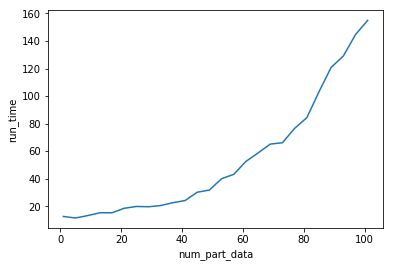

In [21]:
#dataframe_vals
df_vals = pd.DataFrame(list_vals)

#plot_vals
sns.lineplot(data = df_vals, x = 'num_part_data',y = 'run_time')

display(df_vals.head(10), plt)

    - Partitioning data-joined when shuffling data for joins or aggregations

In [22]:
df_1_wop = spark.read.parquet('df_1_wop.parquet')
list_vals_2 = []
dict_vals_2 = {}

# Shuffled hash join (varing partitioning of data-joined)
for i in range (1, 1050,25):
    
    spark.conf.set("spark.sql.shuffle.partitions", i)  
    start_time = time.time() #t0
       
    df_1 = df_1_wop
    df_2 = df_1
    df_joined = df_1.join(df_2, 
         (df_1.MONTH == df_2.MONTH) & 
         (df_1.DAY == df_2.DAY) &
         (df_1.AIRLINE == df_2.AIRLINE) &
         (df_1.FLIGHT_NUMBER == df_2.FLIGHT_NUMBER)
         , how = 'left')
    print(i)
    t_wop = time.time() - start_time
    dict_vals_2 = {'num_part_data': df_1_wop.rdd.getNumPartitions(), 'run_time': (time.time() - start_time), 'num_part_data_joined': df_joined.rdd.getNumPartitions()}
    list_vals_2.append(dict_vals_2)
    gc.collect()

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DIS

,num_part_data,num_part_data_joined,run_time
0,8,1,24.348292
1,8,26,3.743493
2,8,51,3.940083
3,8,76,4.803571
4,8,101,5.146393
5,8,126,5.093621
6,8,151,5.959509
7,8,176,6.049354
8,8,201,4.526142
9,8,226,3.804941


<module 'matplotlib' from 'C:\\Users\\mnasca\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\__init__.py'>

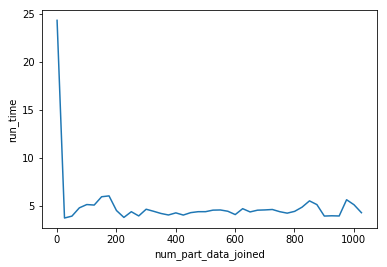

In [23]:
#dataframe_vals
df_vals_2 = pd.DataFrame(list_vals_2)

#plot_vals
sns.lineplot(data = df_vals_2, x = 'num_part_data_joined',y = 'run_time')

display(df_vals_2.head(10), plt)

    - Partitioning data-source by spcific columns + Partitioning data-joined

In [40]:
df_flights.write.mode('overwrite').partitionBy('MONTH','DAY','AIRLINE').format("parquet").save('df_1_wp.parquet')
df_1_wp = spark.read.parquet('df_1_wp.parquet') #Partitions: 157

list_vals_3 = []
dict_vals_3 = {}

# Shuffled hash join (varing partitioning of data-joined)
for i in range (1,1050,50):
    
    spark.conf.set("spark.sql.shuffle.partitions", i)  
    start_time = time.time() #t0
       
    df_1 = df_1_wp
    df_2 = df_1
    df_joined = df_1.join(df_2, 
         (df_1.MONTH == df_2.MONTH) & 
         (df_1.DAY == df_2.DAY) &
         (df_1.AIRLINE == df_2.AIRLINE) &
         (df_1.FLIGHT_NUMBER == df_2.FLIGHT_NUMBER)
         , how = 'left')
    print(i)
    t_wop = time.time() - start_time
    dict_vals_3 = {'num_part_data': df_1_wp.rdd.getNumPartitions(), 'run_time': (time.time() - start_time), 'num_part_data_joined': df_joined.rdd.getNumPartitions()}
    list_vals_3.append(dict_vals_3)
    gc.collect()

+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+
|YEAR|DAY_OF_WEEK|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TA

+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+
|YEAR|DAY_OF_WEEK|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TA

+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+
|YEAR|DAY_OF_WEEK|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TA

+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+
|YEAR|DAY_OF_WEEK|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TA

+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+
|YEAR|DAY_OF_WEEK|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TA

+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+
|YEAR|DAY_OF_WEEK|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TA

+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+
|YEAR|DAY_OF_WEEK|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TA

+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+
|YEAR|DAY_OF_WEEK|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TA

+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+
|YEAR|DAY_OF_WEEK|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TA

+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+
|YEAR|DAY_OF_WEEK|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TA

+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+
|YEAR|DAY_OF_WEEK|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TA

+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+
|YEAR|DAY_OF_WEEK|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TA

+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+
|YEAR|DAY_OF_WEEK|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TA

+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+----+-----------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----+---+-------+
|YEAR|DAY_OF_WEEK|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TA

,num_part_data,num_part_data_joined,run_time
0,157,1,32.003620
1,157,26,16.769118
2,157,51,24.366834
3,157,76,38.774959
4,157,101,58.042248
5,157,126,82.958913
6,157,151,125.045999
7,157,176,189.374626
8,157,201,27.158312
9,157,226,21.262928


<module 'matplotlib' from 'C:\\Users\\mnasca\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\__init__.py'>

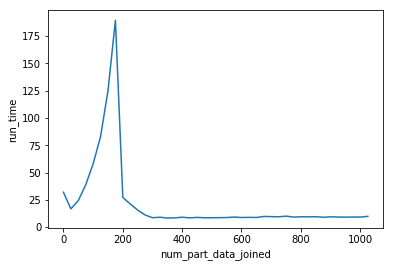

In [44]:
#dataframe_vals
df_vals_3 = pd.DataFrame(list_vals_3)

#plot_vals
sns.lineplot(data = df_vals_3, x = 'num_part_data_joined',y = 'run_time')

display(df_vals_3.head(15), plt)


> If there is no partitioner the partitioning is not based upon characteristic of data but distribution is random and uniformed across nodes. These way-joins are expensive because the network can become congested with traffic, especially if your data is not partitioned well.


Depending on your use case, the partitioning can be benefitial or harmfull. One can see that the data volume is not enough to fill all the partitions when there are 200 of them, which causes unnecessary operations, and ultimately causes the creation of very small files, which is not desirable. If however you have too little partitions, and lots of data to process, each of your executors memory might not be enough/available to process so much at one given time, causing errors like this _java.lang.OutOfMemoryError: Java heap space_. Remember that each partition is a unit of processing in Spark.

<p style="text-align: center;">
Understanding how Spark deals with partitions allow us to control the application parallelism (which leads to better cluster utilization — fewer costs).
<p>

> Performance Tuning

**Take a look at your application with care and figure out what your ideal partition number is. Working with dataframes usually brings more optimizations, but don’t forget to set the** _spark.sql.shuffle.partitions_ **configuration to a value that suits your use case.**

Consulted bibliography

        https://www.youtube.com/watch?v=WyfHUNnMutg
        
        https://spark.apache.org/docs/latest/sql-performance-tuning.html
        
        https://medium.com/parrot-prediction/partitioning-in-apache-spark-8134ad840b0
        
        https://dzone.com/articles/an-intro-to-apache-spark-partitioning-what-you-nee